## Day 34 Lecture 2 Assignment

In this assignment, we will learn about gradient boosting. We will use a dataset of house information in Ames, Iowa, predicting sale price.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
house = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/houseprices.csv')
print(house.shape)
house.head()

(1460, 81)


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Check for nulls. Remove any columns with more than 100 nulls, then drop any remaining rows with nulls after that.

In [3]:
# your work here
house.isnull().mean().sort_values(ascending=False)

poolqc           0.995205
miscfeature      0.963014
alley            0.937671
fence            0.807534
fireplacequ      0.472603
                   ...   
centralair       0.000000
salecondition    0.000000
heating          0.000000
totalbsmtsf      0.000000
id               0.000000
Length: 81, dtype: float64

In [4]:
#function for percentage of missing data
def missingness_summary(df,print_log,sort):
  percentage_null = df.isnull().sum()*100/df.isnull().count()
  if sort == 'ascending':
    return percentage_null.sort_values()
  elif sort == 'descending':
    return percentage_null.sort_values(ascending=False)
  else: 
    return percentage_null

In [5]:
house1 = missingness_summary(house,0,'descending')

In [6]:
#columns with missing data over 10%
house1.loc[house1 > 10.0].index

Index(['poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ',
       'lotfrontage'],
      dtype='object')

In [7]:
house.drop(['alley', 'miscfeature', 'fence', 'poolqc', 'fireplacequ', 'lotfrontage'], axis=1, inplace=True)

In [8]:
house.dropna(inplace=True)

In [9]:
house.shape

(1338, 75)

One hot encode your categorical features using get_dummies.

In [10]:
# your work here
house_cat = house.select_dtypes(include=object)
cat = pd.get_dummies(house_cat,drop_first=True)
print(cat.shape)
cat.head()

(1338, 191)


,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,lotshape_IR2,lotshape_IR3,lotshape_Reg,landcontour_HLS,landcontour_Low,landcontour_Lvl,utilities_NoSeWa,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,landslope_Mod,landslope_Sev,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,...,electrical_SBrkr,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagefinish_RFn,garagefinish_Unf,garagequal_Fa,garagequal_Gd,garagequal_Po,garagequal_TA,garagecond_Fa,garagecond_Gd,garagecond_Po,garagecond_TA,paveddrive_P,paveddrive_Y,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [11]:
cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1459
Columns: 191 entries, mszoning_FV to salecondition_Partial
dtypes: uint8(191)
memory usage: 260.0 KB


In [12]:
house = pd.concat([house, cat], axis=1)
print(house.shape)
house.head()

(1338, 266)


,id,mssubclass,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,...,electrical_SBrkr,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagefinish_RFn,garagefinish_Unf,garagequal_Fa,garagequal_Gd,garagequal_Po,garagequal_TA,garagecond_Fa,garagecond_Gd,garagecond_Po,garagecond_TA,paveddrive_P,paveddrive_Y,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,...,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,...,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [13]:
house.drop(columns=house_cat, axis=1, inplace=True)
house.head()

,id,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,...,electrical_SBrkr,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagefinish_RFn,garagefinish_Unf,garagequal_Fa,garagequal_Gd,garagequal_Po,garagequal_TA,garagecond_Fa,garagecond_Gd,garagecond_Po,garagecond_TA,paveddrive_P,paveddrive_Y,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,1,60,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,0,0,1,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,0,0,1,...,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,3,60,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,0,0,1,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,4,70,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,0,0,1,...,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,5,60,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000,0,0,1,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


Take a look at your outcome variable. It is highly skewed, and has a few very rare large outliers.

Let's try log transforming the y variable.

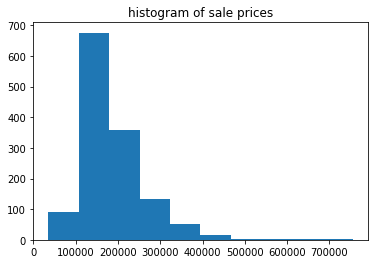

In [14]:
# your work here
plt.hist(house['saleprice'])
plt.title('histogram of sale prices')
plt.show()

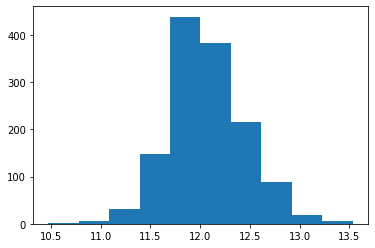

In [15]:
plt.hist(np.log1p(house['saleprice']))
plt.show()

We know that there are some rare large values. We can make sure that the training and test sets have about the same distribution by stratifying the train-test split.

Split your training and test sets, with a test size of 0.2. Use the given helper function to stratify the continuous outcome. Remember that the outcome variable is now the **log of sale price**.

In [16]:
def binned(y, num_bins):
    # Creates an object to put in the stratify keyword in train_test_split
    # Specify number of bins to separate your y variable
    ymin, ymax = y.min(), y.max()
    bins = np.linspace(ymin, ymax, num_bins+1)[:-1]
    y_binned = np.digitize(y, bins)
    return y_binned

In [17]:
# your work here
from sklearn.model_selection import train_test_split
X = house.drop(['saleprice'], axis=1)
y = np.log1p(house['saleprice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=binned(y,3))

Create a Gradient Boosting Regressor model. Measure the MAE (Mean Absolute Error) for the training and testing sets.

In [18]:
from sklearn.metrics import mean_absolute_error
def scores(model, X, y):
  r2 = model.score(X, y)
  y_pred = model.predict(X)
  #squared=False turns MSE into RMSE
  mae = mean_absolute_error(y, y_pred)
  return r2, mae 

def results(model, X_train, X_test, y_train, y_test):
  r2_train, mae_train = scores(model, X_train, y_train)
  r2_test, mae_test = scores(model, X_test, y_test)
  return ('Train\tR2: {:.5f}\tMAE: {:.5f}\n' +
          'Test\tR2: {:.5f}\tMAE: {:.5f}').format(r2_train, mae_train,
                                                   r2_test, mae_test)

In [20]:
# your work here
from sklearn.ensemble import GradientBoostingRegressor

#having default parameters first
grad = GradientBoostingRegressor()
grad.fit(X_train, y_train)

print(results(grad, X_train, X_test, y_train, y_test))

Train	R2: 0.96240	MAE: 0.05571
Test	R2: 0.88501	MAE: 0.08639


Create a grid search. Try varying subsample, learning rate, and max features. Use MAE as your scoring metric.

In [21]:
# your work here
from sklearn.model_selection import GridSearchCV

params = {'learning_rate': [0.05, 0.1, 0.2], 'subsample': [.8, .9, 1.0], 'max_features': [0.75, 0.9, 1],
          'n_iter_no_change': [10], 'n_estimators': [1000]}

grid = GridSearchCV(grad, param_grid=params, scoring='neg_mean_absolute_error' ,cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [23]:
#best parameters
print('Best learning rate:', grid.best_estimator_.learning_rate)
print('Best subsample:', grid.best_estimator_.subsample)
print('Best max features:', grid.best_estimator_.max_features)

Best learning rate: 0.1
Best subsample: 0.8
Best max features: 0.75


Create residual plots of the training and test sets and interpret your results.

In [25]:
grad_best = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1000, subsample=0.8, 
                                      max_features=0.75, n_iter_no_change=10)
grad_best.fit(X_train, y_train)
print('Best parameters for Gradient Boosting:\n', results(grad_best, X_train, X_test, y_train, y_test))

Best parameters for Gradient Boosting:
 Train	R2: 0.96364	MAE: 0.05347
Test	R2: 0.88136	MAE: 0.08700


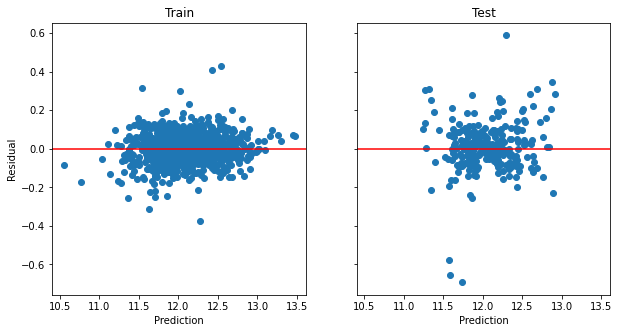

In [27]:
# your work here
#residual plot
pred_train = grad_best.predict(X_train)
pred_test = grad_best.predict(X_test)

res_train = y_train - pred_train
res_test = y_test - pred_test

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(pred_train, res_train)
ax[0].axhline(0, c='r')
ax[0].set_ylabel('Residual')
ax[0].set_xlabel('Prediction')
ax[0].set_title('Train')
ax[1].scatter(pred_test, res_test)
ax[1].axhline(0, c='r')
ax[1].set_xlabel('Prediction')
ax[1].set_title('Test')
plt.show()

In [ ]:
#For the train set the data points are very closely clustered to 0 so there could be some overfitting in the model
#For the test set there are some outliers being shown in the plot above. 
# The data points are clustered near the 0 line as well but not as closely as the train